
# Previsão de Temperatura com Modelos de Deep Learning

Este projeto visa prever a temperatura horária (°C) com 24 horas de antecedência utilizando dados meteorológicos da estação Jena, Alemanha, no período de 2009 a 2016.

A modelagem considera três arquiteturas principais: LSTM e GRU, avaliadas em relação ao erro absoluto médio (MAE).


## 1. Importação de Bibliotecas

In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential, Model
from keras.layers import LSTM, GRU, Dense, Input, MultiHeadAttention, GlobalAveragePooling1D


## 2. Carregamento e Análise Exploratória dos Dados

In [12]:

df = pd.read_csv("jena_climate_2009_2016.csv")
df["Date Time"] = pd.to_datetime(df["Date Time"], dayfirst=True)
df = df.set_index("Date Time")

df.shape, df.columns


((420551, 14),
 Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
        'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
        'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
        'wd (deg)'],
       dtype='object'))

### 2.1. Análise Exploratória dos Dados

In [7]:
print("Time range:", df.index.min(), "→", df.index.max())

Time range: 2009-01-01 00:10:00 → 2017-01-01 00:00:00


In [8]:
df.isnull().sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

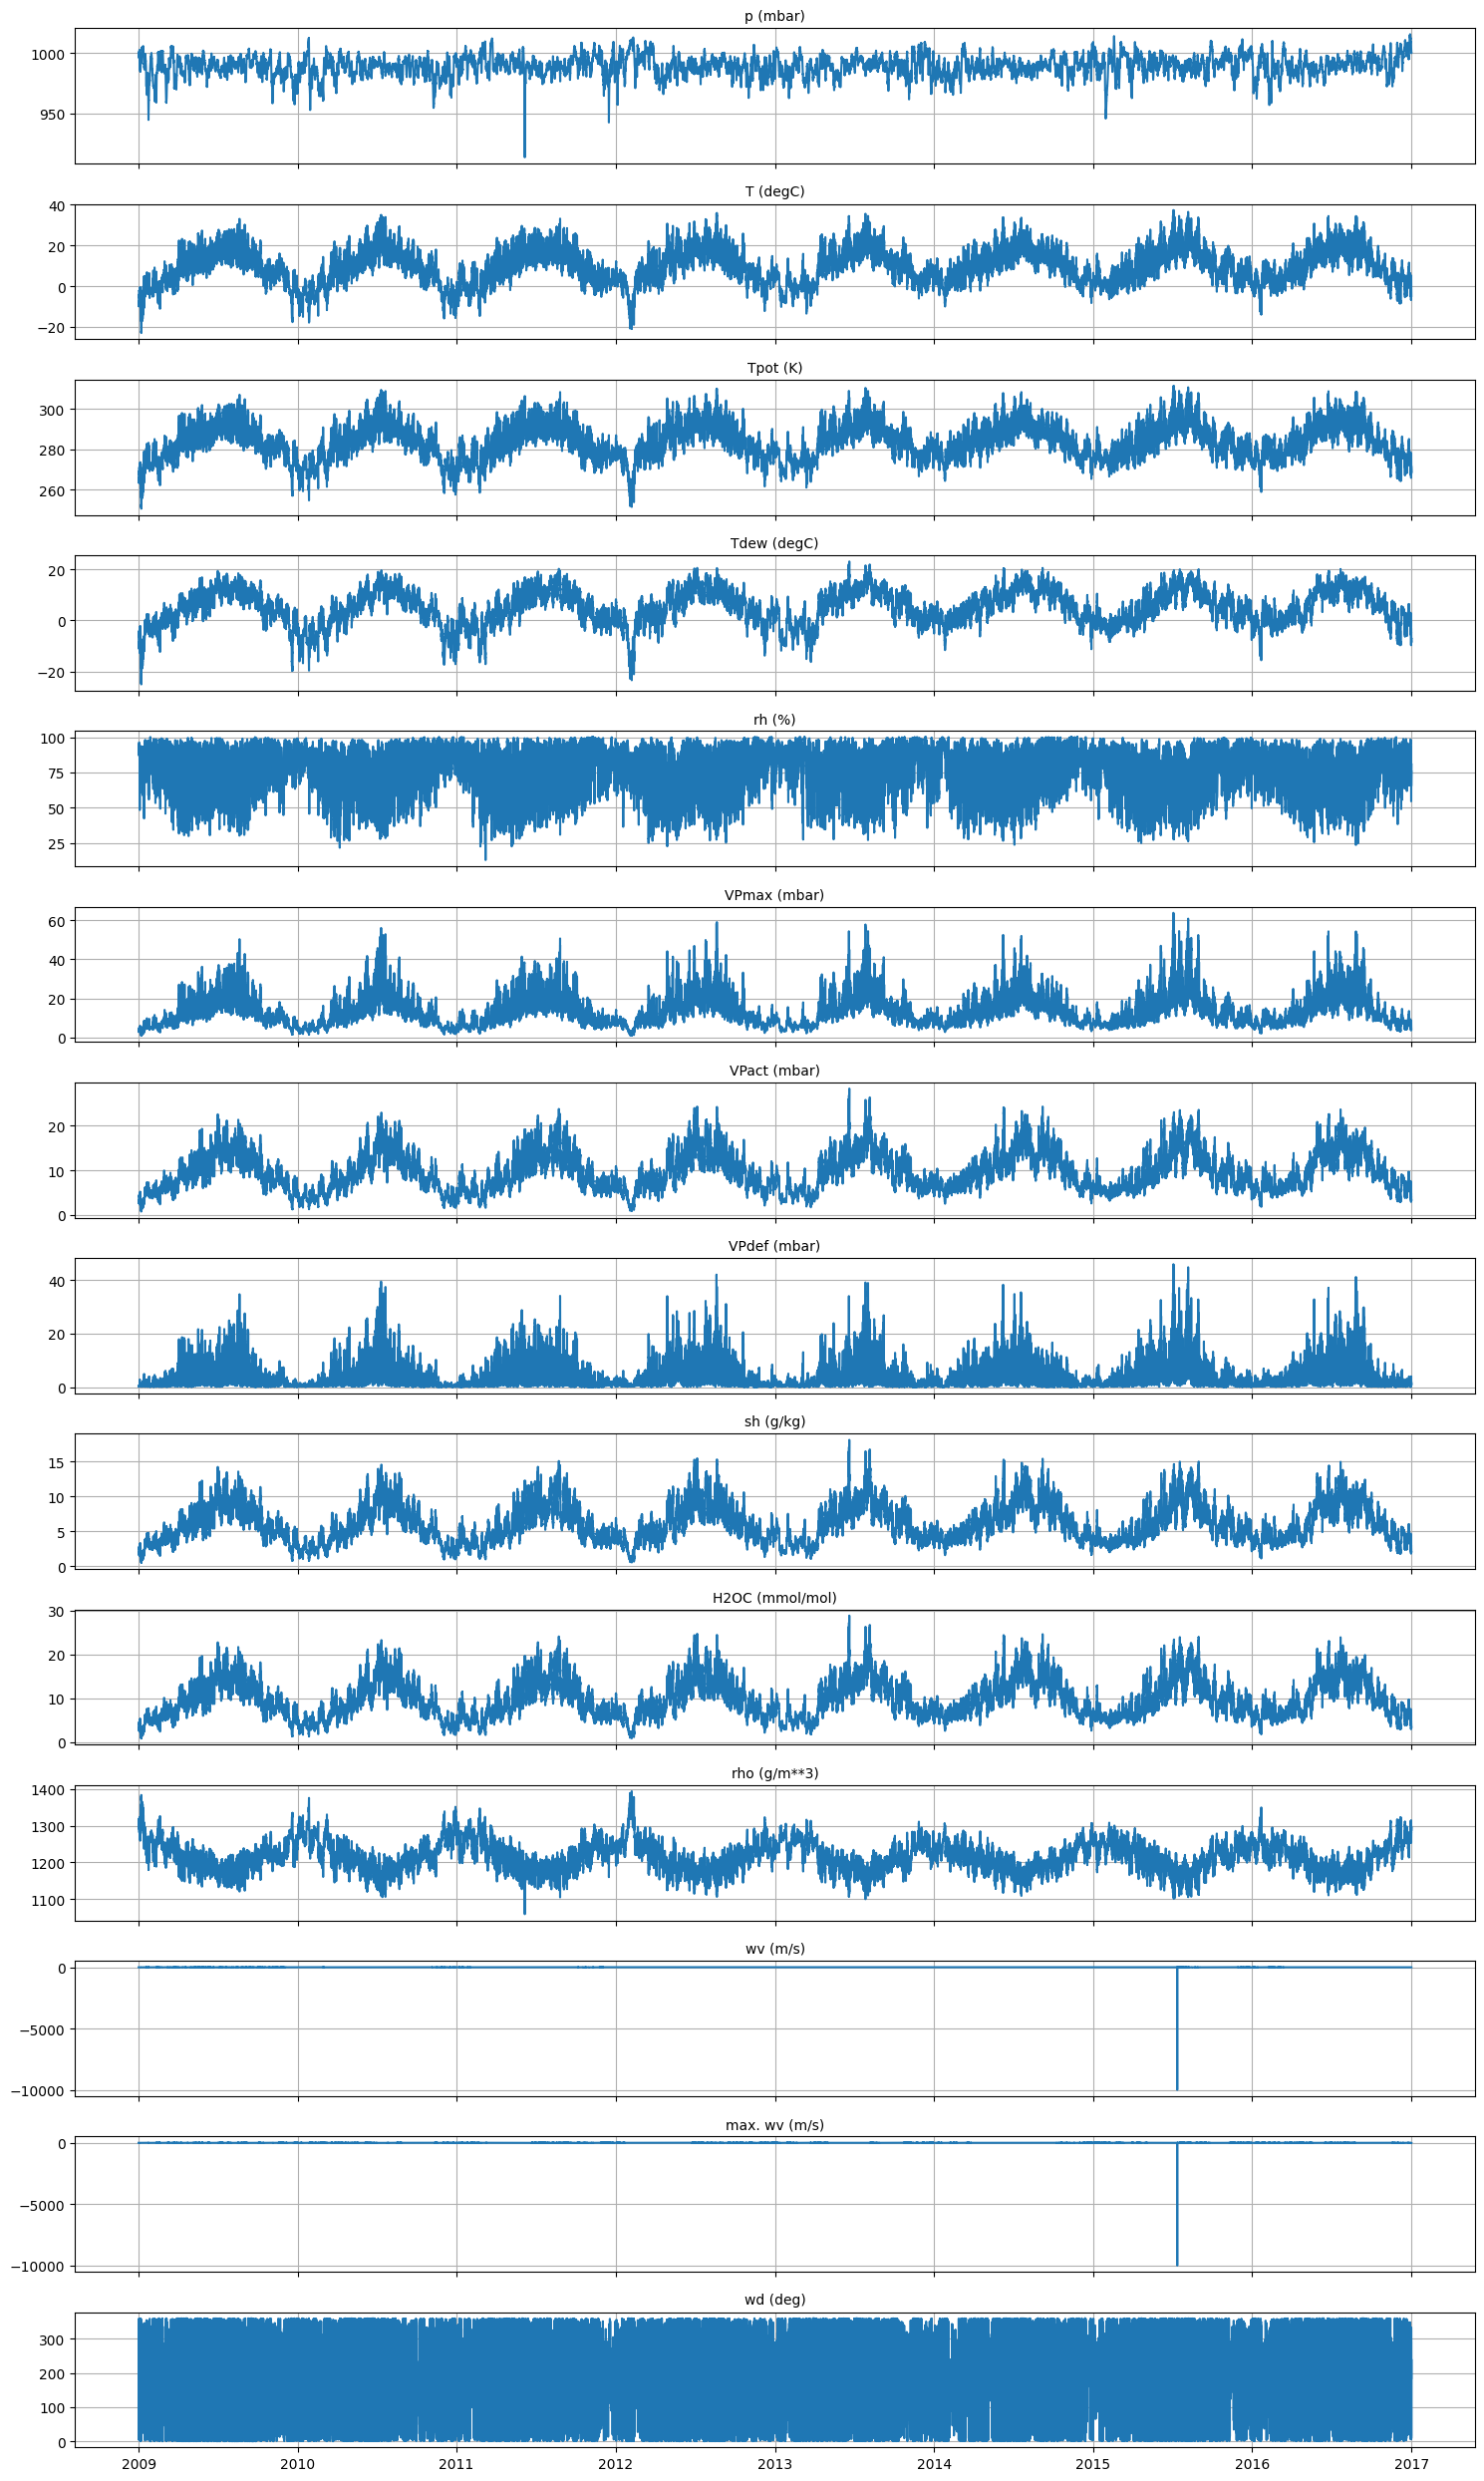

In [13]:
fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(15, 25), sharex=True)

for i, col in enumerate(df.columns):
    axes[i].plot(df.index, df[col])
    axes[i].set_title(col, fontsize=10)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

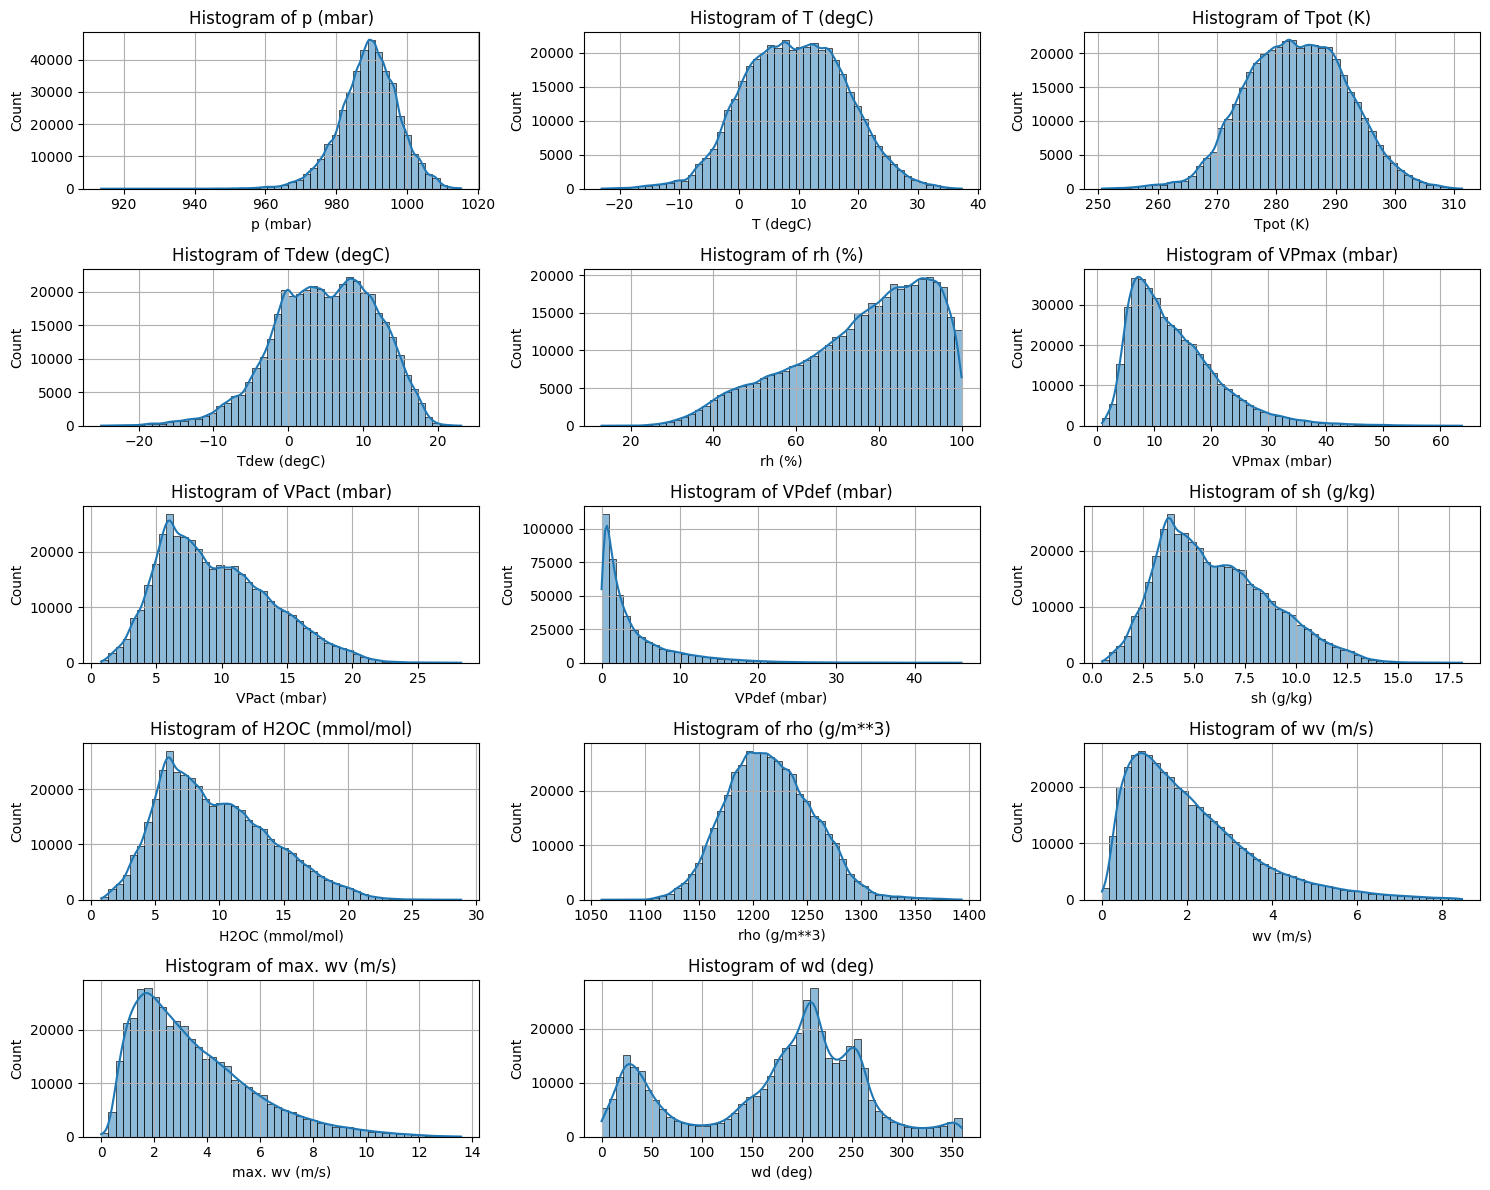

In [17]:
# Número de colunas
n_cols = 3
n_rows = int(len(df.columns) / n_cols) + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True, bins=50)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].grid(True)

# Remove subplots vazios se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 2.3. Análise de Outliers
Ao analisar os dados, é possível identificar claramente a presença de outliers nas variáveis wv (m/s) e max. wv (m/s). Para tratar essas anomalias, será aplicado o método da distância interquartílica (IQR - Interquartile Range), que é uma técnica robusta e amplamente utilizada para a detecção e remoção de valores extremos em distribuições numéricas.

In [14]:
Q1 = df['wv (m/s)'].quantile(0.25)
Q3 = df['wv (m/s)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter out values outside the bounds
df = df[(df['wv (m/s)'] >= lower_bound) & (df['wv (m/s)'] <= upper_bound)]

In [16]:
Q1 = df['max. wv (m/s)'].quantile(0.25)
Q3 = df['max. wv (m/s)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter out values outside the bounds
df = df[(df['max. wv (m/s)'] >= lower_bound) & (df['max. wv (m/s)'] <= upper_bound)]

### 2.2. Seleção de Features e Frequência Temporal
O objetivo deste projeto é realizar previsões horárias da temperatura para as próximas 24 horas. Por esse motivo, optei por reamostrar os dados para uma frequência temporal de 1 hora, garantindo que o modelo receba informações compatíveis com a escala de tempo das previsões desejadas.

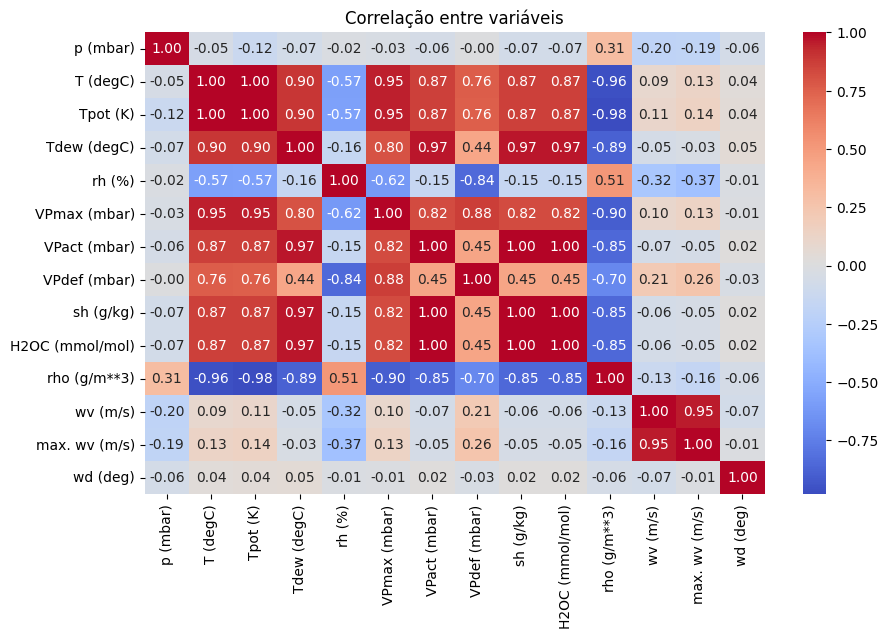

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlação entre variáveis")
plt.show()

VPact, sh, and H2OC - Essas três são perfeitamento correlacionadas entre si, logo vou escolher apenas uma para não haver redundancia.

p (mbar), wv e max. wv - correlação muito fraca com a temperatura


In [19]:

features = ['rh (%)', 'VPmax (mbar)', 'VPdef (mbar)', 
            'sh (g/kg)', 'rho (g/m**3)']
target = 'T (degC)'

# Checagem de frequências
freqs = df.index.to_series().diff().value_counts().head()
print("Top time deltas:\n", freqs)

# Resample para 1h se necessário
df = df[features + [target]].resample('1H').mean().interpolate()


Top time deltas:
 Date Time
0 days 00:10:00    418023
0 days 00:20:00       335
0 days 00:30:00       133
0 days 00:40:00        51
0 days 00:50:00        35
Name: count, dtype: int64


## 3. Preparação de Dados para Modelagem

In [ ]:

scaler = StandardScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)

input_width = 336
label_width = 24

def create_sequences(data, input_width, label_width):
    X, y = [], []
    for i in range(len(data) - input_width - label_width):
        X.append(data[i:i+input_width, :-1])
        y.append(data[i+input_width:i+input_width+label_width, -1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_df.values, input_width, label_width)

train_size = int(0.7 * len(X_seq))
val_size = int(0.2 * len(X_seq))
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]


## 4. Modelagem e Avaliação

### 4.1 LSTM

In [48]:

model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(input_width, len(features))),
    Dense(64, activation='relu'),
    Dense(label_width)
])
model_lstm.compile(optimizer='adam', loss='mae')
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, shuffle=False)


Epoch 1/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.3409 - val_loss: 0.3426
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 0.2699 - val_loss: 0.3138
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2579 - val_loss: 0.3075
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2521 - val_loss: 0.2907
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2477 - val_loss: 0.2864
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2439 - val_loss: 0.2849
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2410 - val_loss: 0.2838
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2386 - val_loss: 0.2842
Epoch 9/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2365 - val_loss: 0.2833
Epoch 10/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2349 - val_loss: 0.2823


### 4.2 GRU

In [49]:
model_gru = Sequential([
    GRU(64, return_sequences=False, input_shape=(input_width, len(features))),
    Dense(64, activation='relu'),
    Dense(label_width)  # Output 24 future steps
])

model_gru.compile(optimizer='adam', loss='mae')
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, shuffle=False)

Epoch 1/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.3274 - val_loss: 0.3049
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2632 - val_loss: 0.2924
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2530 - val_loss: 0.2859
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2475 - val_loss: 0.2770
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2436 - val_loss: 0.2732
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2405 - val_loss: 0.2701
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2380 - val_loss: 0.2688
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2360 - val_loss: 0.2695
Epoch 9/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 0.2341 - val_loss: 0.2699
Epoch 10/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2324 - val_loss: 0.2713


## 5. Avaliação no Conjunto de Teste

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


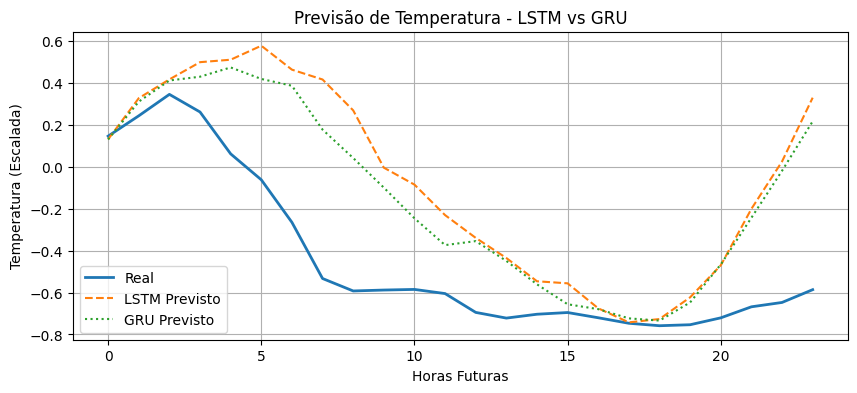

MAE LSTM: 0.2422
MAE GRU: 0.2342


In [50]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)

sample_idx = 77

plt.figure(figsize=(10, 4))
plt.plot(y_test[sample_idx], label='Real', linewidth=2)
plt.plot(y_pred_lstm[sample_idx], label='LSTM Previsto', linestyle='--')
plt.plot(y_pred_gru[sample_idx], label='GRU Previsto', linestyle=':')
plt.title("Previsão de Temperatura - LSTM vs GRU")
plt.xlabel("Horas Futuras")
plt.ylabel("Temperatura (Escalada)")
plt.legend()
plt.grid(True)
plt.show()

# Calculate MAE
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mae_gru = mean_absolute_error(y_test, y_pred_gru)

print(f"MAE LSTM: {mae_lstm:.4f}")
print(f"MAE GRU: {mae_gru:.4f}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


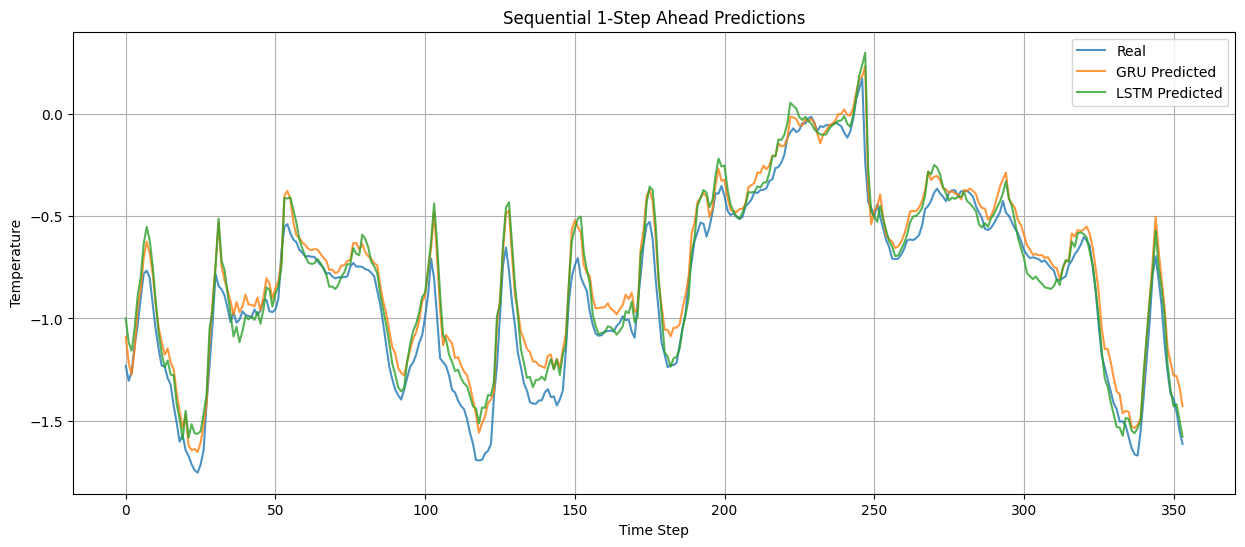

In [51]:
y_test_seq = y_test[:, 0]

y_pred_esc_gru = model_gru.predict(X_test)
y_pred_esc_lstm = model_lstm.predict(X_test)

y_pred_seq_gru = y_pred_esc_gru[:, 0]
y_pred_seq_lstm = y_pred_esc_lstm[:, 0]

plt.figure(figsize=(15, 6))
plt.plot(y_test_seq[-354:], label='Real', alpha=0.8)
plt.plot(y_pred_seq_gru[-354:], label='GRU Predicted', alpha=0.8)
plt.plot(y_pred_seq_lstm[-354:], label='LSTM Predicted', alpha=0.8)
plt.title(f"Sequential {1}-Step Ahead Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

### 5.1. Análise de Resíduos

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


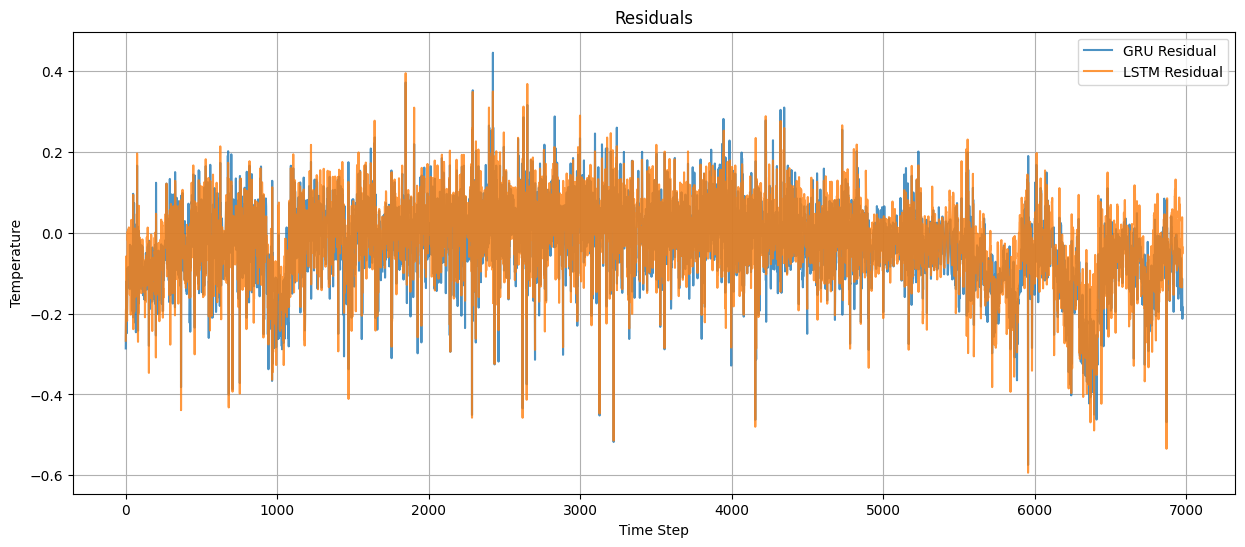

In [52]:
y_test_seq = y_test[:, 0]

y_pred_esc_gru = model_gru.predict(X_test)
y_pred_esc_lstm = model_lstm.predict(X_test)

y_pred_seq_gru = y_pred_esc_gru[:, 0]
y_pred_seq_lstm = y_pred_esc_lstm[:, 0]

gru_residuals = y_test_seq - y_pred_esc_gru[:, 0]
lstm_residuals = y_test_seq - y_pred_esc_lstm[:, 0]

plt.figure(figsize=(15, 6))
plt.plot(gru_residuals, label='GRU Residual', alpha=0.8)
plt.plot(lstm_residuals, label='LSTM Residual', alpha=0.8)
plt.title(f"Residuals")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

- Resíduos oscilam em torno de zero.
- Não seguem um padrão

Até em tão tudo certo com a regressão

In [53]:
print(f"Média dos resíduos GRU: {gru_residuals.mean():.4f}")
print(f"Média dos resíduos LSTM: {lstm_residuals.mean():.4f}")


Média dos resíduos GRU: -0.0301
Média dos resíduos LSTM: -0.0186


Média dos residuos dos dois modelos igual a zero como esperado

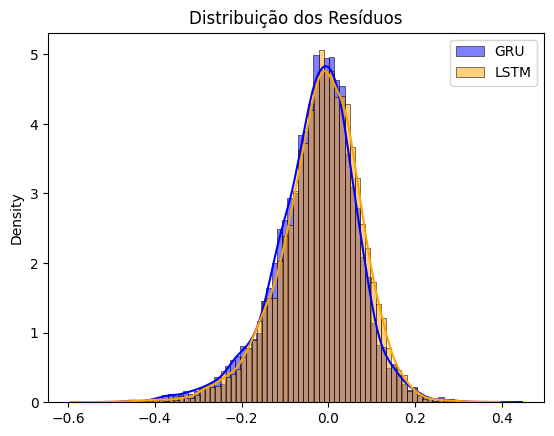

In [54]:
import seaborn as sns
sns.histplot(gru_residuals, kde=True, color='blue', label='GRU', stat='density')
sns.histplot(lstm_residuals, kde=True, color='orange', label='LSTM', stat='density')
plt.legend()
plt.title("Distribuição dos Resíduos")
plt.show()


Eles seguem uma distribuição normal como esperado

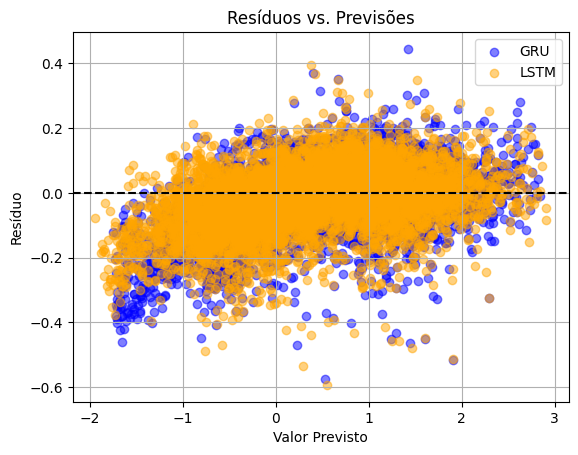

In [55]:
plt.scatter(y_pred_seq_gru, gru_residuals, alpha=0.5, label='GRU', color='blue')
plt.scatter(y_pred_seq_lstm, lstm_residuals, alpha=0.5, label='LSTM', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title("Resíduos vs. Previsões")
plt.xlabel("Valor Previsto")
plt.ylabel("Resíduo")
plt.legend()
plt.grid(True)
plt.show()


Nenhuma heterocedasticidade possivel de ser visualizada nesse gráfico

## 6. Discussão e Conclusão

Ambos os modelos **LSTM** e **GRU** demonstraram boa capacidade de prever a temperatura horária com até 24 horas de antecedência.

O **GRU apresentou desempenho ligeiramente superior**, o que pode ser explicado por sua **arquitetura mais simples e eficiente**, sendo menos propenso ao overfitting em conjuntos de dados de tamanho moderado.

Dado o **custo computacional menor** do GRU e sua **performance competitiva**, ele é o modelo mais indicado neste cenário.
